In [1]:
import os
if not 'changed' in globals():
    current_path = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_path)
    os.chdir(parent_dir)
    changed = True

EMBED = False

In [2]:
import cv2, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.display import Video, display, HTML
from pathlib import Path
import torch, json, random
import src.wrappers.wrapers as wrapers
import re

tl_big = matplotlib.colormaps['twilight_shifted'].resampled(int(1e3))
tl_resc = matplotlib.colors.ListedColormap(tl_big(np.linspace(0.075, 0.925, 10000)))

def load_model(model_path):
    path = Path(model_path)
    
    config = json.load(open(path.parent.parent/'config.json'))
    checkpoint = torch.load(path.as_posix(), map_location=torch.device('cuda:0'))
    
    model = getattr(wrapers, config["MODEL_WRAPER"])(config)
    model.load_state_dict(checkpoint['state_dict'])

    return model, config

def predict(model, full_vertex, positional_encoding: bool, axis = 3):   
    pred = np.zeros_like(full_vertex)
    for i_cnt in range(full_vertex.shape[0]):
        for j_cnt in range(full_vertex.shape[1]):
            r_cnt = random.randint(0, full_vertex.shape[2] - 1)

            if axis == 1:
                i, j, r = r_cnt, i_cnt, j_cnt
            elif axis == 2:
                i, j, r = i_cnt, r_cnt, j_cnt
            elif axis == 3:
                i, j, r = i_cnt, j_cnt, r_cnt
            else:
                raise NotImplementedError("Axis not implemented")
            
            if positional_encoding:
                pos = torch.tensor([i, j, r], dtype=torch.float32).to("cpu")

            dim1 = full_vertex[i, j, :]
            dim2 = full_vertex[i, :, r]
            dim3 = full_vertex[:, j, r]
            full_input = torch.tensor([*dim1, *dim2, *dim3], dtype=torch.float32).to("cpu")
            if positional_encoding:
                full_input = (pos.unsqueeze(0), full_input.unsqueeze(0))
            if axis == 1:
                pred[:, j, r] = model(full_input).detach().numpy()
            elif axis == 2:
                pred[i, :, r] = model(full_input).detach().numpy()
            elif axis == 3:
                pred[i, j, :] = model(full_input).detach().numpy()
            else:
                raise NotImplementedError("Axis not implemented")
            
            del dim1, dim2, dim3, full_input
    return pred

def get_full_path_from_vertex_path(vertex_path: str):
    vertex_base_path = "D:\\FRGS\\"
    return vertex_base_path + vertex_path + ".h5"

def get_vertex_from_filepath(path: str):
    with h5py.File(path, 'r') as f:
        for name, data in f["V"].items():
            if name.startswith("step"):
                return data[()]

def create_video_for_vertex(vertex, output_video, frame_rate, axis=1):

    # Create VideoWriter object with codec and frame settings
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    width, height = 576, 576  # Set resolution for the video
    out = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))
    max_val = np.max(vertex)

    for i in range(576):
        # Create a matplotlib figure and canvas
        fig, ax = plt.subplots(figsize=(width / 100.0, height / 100.0), dpi=100)

        # Generate data and plot it (you can replace this with your own plot logic)
        if axis == 1:
            data = vertex[i, :, :]
        elif axis == 2:
            data = vertex[:, i, :]
        elif axis == 3:
            data = vertex[:, :, i]
        else:
            raise NotImplementedError("Axis not implemented")

        ax.set_axis_off()
        ax.set_title(f"k={i}")

        im = ax.imshow(data, cmap=tl_resc, vmin=0, vmax=max_val)

        fig.colorbar(im, ax=ax)

        # Draw the canvas and convert to an image
        canvas = FigureCanvas(fig)
        canvas.draw()
        img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Write the image to the video
        out.write(img_bgr)

        # Close the figure to prevent memory leaks
        plt.close(fig)

    out.release()
    print(f"Video {output_video} created successfully!")

def create_and_display_video(vertex_path, axis, model_path=None):
    if model_path:
        model_path = model_path.replace("\\","/")
        model_name = "_rec_" + re.search(r"saves(.*)\.ckpt", model_path).group(1).replace("/","_")
    output_video = f"videos\\{vertex_path}_axis{axis}{model_name if model_path else ''}.mp4"
    frame_rate = 10

    full_vertex_path = get_full_path_from_vertex_path(vertex_path)
    vertex = get_vertex_from_filepath(full_vertex_path)

    if not os.path.isfile(output_video):
        if not model_path:
            prediction = np.zeros_like(vertex)
        else:
            model, config = load_model(model_path)  
            prediction = predict(model, vertex, positional_encoding=config["positional_encoding"], axis=config.get("construction_axis", 3))
        create_video_for_vertex(np.abs(vertex - prediction), output_video, frame_rate, axis=axis)

    if EMBED:
        display(Video(output_video, embed=True))

def create_cross_section_for_k(k_list: list, vertex, axis=1):

    max_val = np.max(vertex)
    fig, ax = plt.subplots(1,len(k_list), figsize=(len(k_list) * 4, 4))
    ax = ax.flatten()
    for i, k in enumerate(k_list):
        if axis == 1:
            data = vertex[k, :, :]
        elif axis == 2:
            data = vertex[:, k, :]
        elif axis == 3:
            data = vertex[:, :, k]
        im = ax[i].imshow(data, cmap=tl_resc, vmax=max_val)       # Use colormap
        ax[i].set_title("k = " + str(k))

        # Remove axes for a cleaner video
        ax[i].set_axis_off()
    fig.colorbar(im, ax=ax)



In [3]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 1
create_and_display_video(vertex_path, axis)

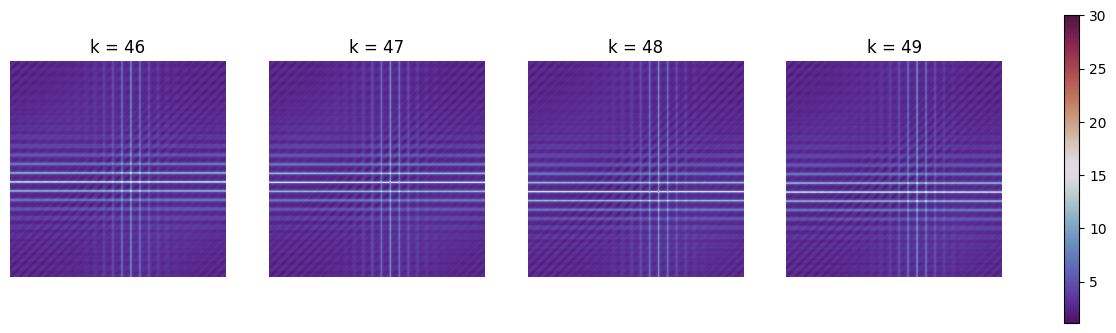

In [4]:
create_cross_section_for_k([46,47,48,49], get_vertex_from_filepath(get_full_path_from_vertex_path(vertex_path)), axis=axis)

In [4]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 2
create_and_display_video(vertex_path, axis)

In [5]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 3
create_and_display_video(vertex_path, axis)

In [6]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 1
model_path = r"C:\Users\Daniel\OneDrive - TU Wien\Uni\6. Semester\Bachelorarbeit\autoencoder\LuttingerWard_from_ML\saves\vertex\konvergenz\v2\checkpoints\best(4648).ckpt"
create_and_display_video(vertex_path, axis, model_path)

In [7]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 2
model_path = r"C:\Users\Daniel\OneDrive - TU Wien\Uni\6. Semester\Bachelorarbeit\autoencoder\LuttingerWard_from_ML\saves\vertex\konvergenz\v2\checkpoints\best(4648).ckpt"
create_and_display_video(vertex_path, axis, model_path)

In [8]:
vertex_path = "tp0.050000_mu0.200000"  # Folder with images
axis = 3
model_path = r"C:\Users\Daniel\OneDrive - TU Wien\Uni\6. Semester\Bachelorarbeit\autoencoder\LuttingerWard_from_ML\saves\vertex\konvergenz\v2\checkpoints\best(4648).ckpt"
create_and_display_video(vertex_path, axis, model_path)